# Pylops - CUDA basic linear operators

### Author: M.Ravasi

In this notebook we will experiment with Pytorch to assess its usability as backend for CUDA enabled operators

In [1]:
!pip install pylops
!pip install git+https://git@github.com/equinor/pylops-gpu.git@master

  Cloning https://git@github.com/equinor/pylops-gpu.git (to revision master) to /tmp/pip-req-build-g53s1047
  Running command git clone -q https://git@github.com/equinor/pylops-gpu.git /tmp/pip-req-build-g53s1047
  Stored in directory: /tmp/pip-ephem-wheel-cache-x6rv6dj0/wheels/c7/f0/0b/513e9be2dad0cbe2a900c0414a94bcae8778093383364aab9a
Successfully built pylops-gpu


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
import scipy as sp
import matplotlib.pyplot as plt
import pylops

from scipy.sparse.linalg import cg
from pylops import Diagonal, MatrixMult
from pylops.utils import dottest
from pylops_gpu.utils.backend import device
from pylops_gpu.utils import dottest as gdottest
from pylops_gpu import Diagonal as gDiagonal
from pylops_gpu import MatrixMult as gMatrixMult
from pylops.signalprocessing import Convolve1D
from pylops_gpu.signalprocessing import Convolve1D as gConvolve1D
from pylops_gpu.optimization.leastsquares import cg as gcg

Populating the interactive namespace from numpy and matplotlib


In [3]:
dev = device()
print('PyLops-gpu working on %s...' % dev)

torch.cuda.empty_cache()

PyLops-gpu working on cuda...


## Diagonal

Example with model and data already on GPU

In [4]:
n = int(1e6)
xg = torch.ones(n, dtype=torch.float32).to(dev)
dg = (torch.arange(0, n, dtype=torch.float32) + 1.).to(dev)

x = xg.cpu().numpy()
d = dg.cpu().numpy()

Dop = Diagonal(d)
Dop_gpu = gDiagonal(dg, device=dev)
dottest(Dop, n, n, verb=True)
gdottest(Dop_gpu, n, n, device=dev, verb=True)

# y = Dx
yg = Dop_gpu * xg
print('y', yg)

Dot test passed, v^T(Opu)=326502146.084215 - u^T(Op^Tv)=326502146.084216
Dot test passed, v^T(Opu)=125043236864.000000 - u^T(Op^Tv)=125043236864.000000
y tensor([1.0000e+00, 2.0000e+00, 3.0000e+00,  ..., 1.0000e+06, 1.0000e+06,
        1.0000e+06], device='cuda:0')


In [5]:
%timeit -n 10 Dop * x
%timeit -n 10 Dop_gpu * xg

10 loops, best of 3: 815 µs per loop
10 loops, best of 3: 16.8 µs per loop


Example with model and data transfered from and to gpu in forward and adjoint operations

Dot test passed, v^T(Opu)=125084549120.000000 - u^T(Op^Tv)=125084549120.000000
y [1.00000e+00 2.00000e+00 3.00000e+00 ... 9.99998e+05 9.99999e+05
 1.00000e+06]


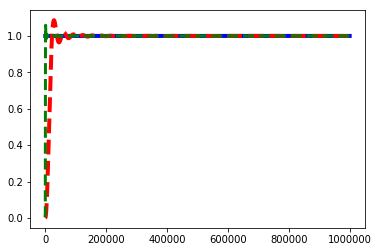

In [6]:
n = int(1e6)
xg = torch.ones(n, dtype=torch.float32).to(dev)
dg = (torch.arange(0, n, dtype=torch.float32) + 1.).to(dev)

xc = xg.cpu()
x = xg.cpu().numpy()
d = dg.cpu().numpy()

Dop = Diagonal(d)
Dop_gpu = gDiagonal(dg, device=dev, togpu=(True, True), tocpu=(True, True))
gdottest(Dop_gpu, n, n, verb=True)

# y = Dx
y = Dop_gpu * x
print('y', y)

# xinv = D^-1 y
xinv = Dop / y
xinvg = (Dop_gpu / torch.from_numpy(y)).numpy() # solver only runs with torch tensors

plt.figure()
plt.plot(x, 'b', lw=4)
plt.plot(xinv, '--r', lw=4)
plt.plot(xinvg, '--g', lw=3)

In [7]:
Dop_gpu = gDiagonal(dg, device=dev, togpu=(True, True))

%timeit -n 10 Dop * x
%timeit -n 10 Dop_gpu * xc

10 loops, best of 3: 741 µs per loop
10 loops, best of 3: 527 µs per loop


In [8]:
Dop_gpu = gDiagonal(dg, device=dev, togpu=(True, True), tocpu=(True, True))

%timeit -n 10 Dop * x
%timeit -n 10 Dop_gpu * xc

10 loops, best of 3: 735 µs per loop
10 loops, best of 3: 1.85 ms per loop


Note here how we get hit by the cost of moving x and y back and forth between CPU and GPU.

Finally we consider the case of broadcasting, where the Diagonal operator is applied to single direction of the input vector x

In [9]:
n = int(1e5)
dg = (torch.arange(0, n, dtype=torch.float32) + 1.).to(dev)
d = dg.cpu().numpy()
xg = (torch.ones(2*n, dtype=torch.float32)).to(dev)
x = xg.cpu().numpy()

Dop2 = Diagonal(d, dims=(n, 2), dir=0)
dottest(Dop2, 2*n, 2*n)

Dop2_gpu = gDiagonal(dg, device=dev, dims=(n, 2), dir=0)
gdottest(Dop2_gpu, 2*n, 2*n, device=dev)

True

In [10]:
%timeit -n 10 Dop2 * x
%timeit -n 10 Dop2_gpu * xg

10 loops, best of 3: 997 µs per loop
10 loops, best of 3: 32 µs per loop


# MatrixMult

In [0]:
n = 2000
niter = 1000

Dot product (vector-vector)

In [12]:
z = np.ones(n, dtype=np.float32)
zgc = torch.ones(n, dtype=torch.float32)
zg = torch.ones(n, dtype=torch.float32).to(dev)

% timeit -n 40 -r 3 z.dot(z)
% timeit -n 40 -r 3 zgc.dot(zgc)
% timeit -n 40 -r 3 zg.dot(zg)
% timeit -n 40 -r 3 zg.matmul(zg)
% timeit -n 40 -r 3 torch.sum(zg*zg)

40 loops, best of 3: 913 ns per loop
40 loops, best of 3: 5.95 µs per loop
40 loops, best of 3: 45.3 µs per loop
40 loops, best of 3: 45.1 µs per loop
40 loops, best of 3: 23.8 µs per loop


Dot product (matrix-vector)

In [13]:
A = np.random.randn(n, n).astype(np.float32)
Agc = torch.from_numpy(A)
Ag = torch.from_numpy(A).to(dev)
zgg = zg.reshape(n, 1)

% timeit -n 40 -r 3 A.dot(z)
% timeit -n 40 -r 3 np.matmul(A, z)
% timeit -n 40 -r 3 Agc.matmul(zgc)
% timeit -n 40 -r 3 Ag.matmul(zg)
% timeit -n 40 -r 3 Ag.mm(zgg)

40 loops, best of 3: 676 µs per loop
40 loops, best of 3: 687 µs per loop
40 loops, best of 3: 737 µs per loop
40 loops, best of 3: 16.3 µs per loop
The slowest run took 8.26 times longer than the fastest. This could mean that an intermediate result is being cached.
40 loops, best of 3: 19.1 µs per loop


We can see how numpy's dot product seem to always win for vector-vector computations but in case of matrix-matrix pytorch on cuda outperforms numpy when n grows (roughly n>500)

In [0]:
def conjgrad(A, b, x, niter):
    'Conjugate-gradient algorithm for minimizing |A x - dat|^2'
    r = b - A._matvec(x)
    d = r.copy()
    k = r.dot(r)
    for iter in range(niter):
        #if iter == 0:
        #  Ad = A._matvec(r)
        #  dAd = r.dot(Ad)
        #else:
        Ad = A._matvec(d)
        dAd = d.dot(Ad)
        a = k / dAd
        x += a*d
        r -= a*Ad
        kold = k
        k = r.dot(r)
        b = k / kold
        d = r + b*d;
    return x
  
def conjgrad_gpu(A, b, x, niter):
    'Conjugate-gradient algorithm for minimizing |A x - dat|^2'
    r = b - A.matmul(x)
    d = r.clone()
    kold = torch.sum(r*r)
    for iter in range(niter):
        Ad = A.matmul(d)
        dAd = torch.sum(d*Ad)
        a = kold / dAd
        x += a*d
        r -= a*Ad
        k = torch.sum(r*r)
        b = k / kold
        d = r + b*d;
        kold = k
    return x

1.336560341676711


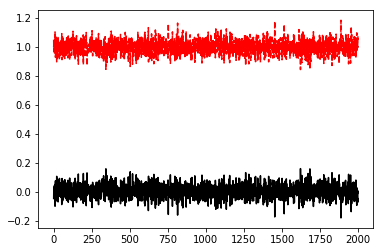

In [15]:
np.random.seed(10)
x = np.ones(n, dtype=np.float32)
A = np.random.randn(n, n).astype(np.float32)
ATA = np.dot(A.T, A)

Aop = MatrixMult(ATA)

y = Aop.matvec(x)
xinv_sp = cg(Aop, y, maxiter=niter)[0]
xinv = conjgrad(Aop, y, np.zeros_like(x), niter)
print(np.linalg.norm(xinv - xinv_sp))

plt.figure()
plt.plot(x)
plt.plot(xinv_sp, '--r')
plt.plot(x-xinv_sp, 'k')

0.15820736


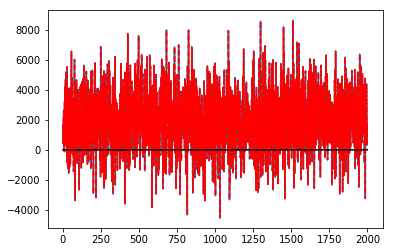

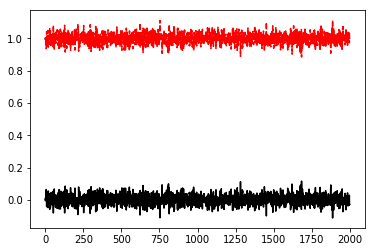

In [16]:
xg = torch.ones(n, dtype=torch.float32).to(dev)
x0g = torch.zeros(n, dtype=torch.float32).to(dev)
Ag = torch.from_numpy(A).to(dev)
ATAg = torch.matmul(Ag.t(), Ag)

yg = ATAg.matmul(xg)
plt.figure()
plt.plot(y)
plt.plot(yg.cpu().numpy(), '--r')
plt.plot(y-yg.cpu().numpy(), 'k')

xinvg = conjgrad_gpu(ATAg, yg, torch.zeros(n, dtype=torch.float32).to(dev), niter)
print(np.linalg.norm(xinv - xinvg.cpu().numpy()))

plt.figure()
plt.plot(x)
plt.plot(xinvg.cpu().numpy(), '--r')
plt.plot(x-xinvg.cpu().numpy(), 'k')

0.15820736


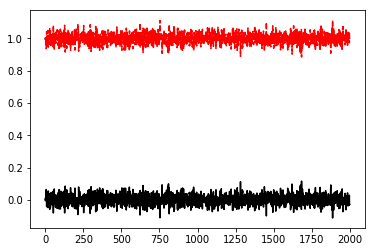

In [17]:
Agop = gMatrixMult(ATAg, device=dev)

xinvg = gcg(Agop, yg, x=torch.zeros(n, dtype=torch.float32).to(dev), niter=niter)[0]
print(np.linalg.norm(xinv - xinvg.cpu().numpy()))

plt.figure()
plt.plot(x)
plt.plot(xinvg.cpu().numpy(), '--r')
plt.plot(x-xinvg.cpu().numpy(), 'k')

In [18]:
niter = 3

%timeit -n 2 cg(Aop, y, maxiter=niter)[0]
%timeit -n 2 conjgrad(Aop, y, np.zeros_like(x), niter)
%timeit -n 2 conjgrad_gpu(ATAg, yg, x0g, niter)
%timeit -n 2 gcg(Agop, yg, x=torch.zeros(n, dtype=torch.float32).to(dev), niter=niter)

2 loops, best of 3: 41.1 ms per loop
2 loops, best of 3: 2.79 ms per loop
2 loops, best of 3: 660 µs per loop
2 loops, best of 3: 861 µs per loop


In [19]:
niter = 500

%timeit -n 2 -r 2 cg(Aop, y, maxiter=niter)[0]
%timeit -n 2 -r 2 conjgrad(Aop, y, np.zeros_like(x), niter)
%timeit -n 2 -r 2 conjgrad_gpu(ATAg, yg, x0g, niter)
%timeit -n 2 gcg(Agop, yg, x=torch.zeros(n, dtype=torch.float32).to(dev), niter=niter)[0]

2 loops, best of 2: 3.75 s per loop
2 loops, best of 2: 357 ms per loop
2 loops, best of 2: 77.8 ms per loop
2 loops, best of 3: 95.1 ms per loop


For large enough problems the gpu implementation of cg seem to greatly outperform scipy as well as our CPU implementation (mostly because the speedup in matrix-vector computation outreaches the slow down in  vector-vector).

# 1D Convolution

In [20]:
N = 11
Nh = 3
x = np.zeros(N)
x[N//2] = 1

h = np.arange(Nh)+1
y = np.convolve(x, h, mode='same')
print(y)
print(y.shape)

[0. 0. 0. 0. 1. 2. 3. 0. 0. 0. 0.]
(11,)


In [21]:
xt = torch.zeros(N)
xt[N//2] = 1

ht = torch.torch.arange(0, Nh, dtype=torch.float) + 1.
yt = torch.torch.conv_transpose1d(xt.reshape(1, 1, N), ht.reshape(1, 1, ht.size()[0]), padding=ht.size()[0]//2)
print(yt)
print(yt.shape)

tensor([[[0., 0., 0., 0., 1., 2., 3., 0., 0., 0., 0.]]])
torch.Size([1, 1, 11])


In [22]:
y = np.correlate(x, h, mode='same')
print(y)

yt = torch.torch.conv1d(xt.reshape(1, 1, N), ht.reshape(1, 1, 3), padding=Nh//2)
print(yt)
print(yt.shape)

[0. 0. 0. 0. 3. 2. 1. 0. 0. 0. 0.]
tensor([[[0., 0., 0., 0., 3., 2., 1., 0., 0., 0., 0.]]])
torch.Size([1, 1, 11])


In [23]:
xt = torch.zeros((1000, N))
xt[:, N//2] = 1
ht = torch.torch.arange(0, Nh, dtype=torch.float) + 1.

xc = xt.to(dev)
hc = ht.to(dev)

yt = torch.torch.conv1d(xt.reshape(1000, 1, N), ht.reshape(1, 1, 3), padding=Nh//2)
print(yt.shape)
yc = torch.torch.conv1d(xc.reshape(1000, 1, N), hc.reshape(1, 1, 3), padding=Nh//2)
print(yc.shape)

% timeit torch.torch.conv1d(xt.reshape(1000, 1, N), ht.reshape(1, 1, 3), padding=Nh//2)
% timeit torch.torch.conv1d(xc.reshape(1000, 1, N), hc.reshape(1, 1, 3), padding=Nh//2)

torch.Size([1000, 1, 11])
torch.Size([1000, 1, 11])
1000 loops, best of 3: 442 µs per loop
The slowest run took 15.62 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 41.4 µs per loop


In [24]:
xt = torch.zeros((1000, 10, N))
xt[:, N//2] = 1
ht = torch.torch.arange(0, Nh, dtype=torch.float) + 1.

xc = xt.to(dev)
hc = ht.to(dev)

yt = torch.torch.conv1d(xt.reshape(1000*10, 1, N), ht.reshape(1, 1, 3), padding=Nh//2)
print(yt.shape)
yc = torch.torch.conv1d(xc.reshape(1000*10, 1, N), hc.reshape(1, 1, 3), padding=Nh//2)
print(yc.shape)

% timeit torch.torch.conv1d(xt.reshape(1000*10, 1, N), ht.reshape(1, 1, 3), padding=Nh//2)
% timeit torch.torch.conv1d(xc.reshape(1000*10, 1, N), hc.reshape(1, 1, 3), padding=Nh//2)

torch.Size([10000, 1, 11])
torch.Size([10000, 1, 11])
100 loops, best of 3: 3.08 ms per loop
The slowest run took 16.62 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 41.6 µs per loop


Let's use the operator

In [43]:
N = 20
Nh = 3
x = np.zeros(N)
x[N//2] = 1

xt = torch.zeros(N)
xt[N//2] = 1

Cop = Convolve1D(N, h, offset=Nh//2)
dottest(Cop, N, N)
y = Cop * x
xadj = Cop.H * y
print(y)
print(xadj)


gCop = gConvolve1D(N, ht, offset=Nh//2)
gdottest(gCop, N, N)
yt = gCop * xt
xadjt = Cop.H * yt
print(y)
print(xadj)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 3. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  3.  8. 14.  8.  3.  0.  0.  0.  0.  0.
  0.  0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 3. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  3.  8. 14.  8.  3.  0.  0.  0.  0.  0.
  0.  0.]


In [44]:
% timeit Cop * x
% timeit gCop * xt

The slowest run took 8.46 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 33.7 µs per loop
The slowest run took 14.89 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 25.9 µs per loop


In [48]:
x = np.zeros((N, 2))
x[N//2] = 1

xt = torch.zeros((N, 2))
xt[N//2] = 1

Cop = Convolve1D(N*2, h, offset=Nh//2, dims=(N, 2))
dottest(Cop, N*2, N*2)
y = Cop * x.ravel()
xadj = Cop.H * y
print(yt)
print(xadjt)

gCop = gConvolve1D(N*2, ht, offset=Nh//2, dims=(N, 2))
gdottest(gCop, N*2, N*2)
yt = gCop * xt.view(-1)
xadjt = Cop.H * yt
print(yt)
print(xadjt)


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 2., 2., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
[-8.88178420e-16 -8.88178420e-16  0.00000000e+00  0.00000000e+00
  1.18423789e-15  1.18423789e-15  2.96059473e-16  2.96059473e-16
  4.44089210e-16  4.44089210e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.28197512e-16  1.28197512e-16
  3.00000000e+00  3.00000000e+00  8.00000000e+00  8.00000000e+00
  1.40000000e+01  1.40000000e+01  8.00000000e+00  8.00000000e+00
  3.00000000e+00  3.00000000e+00  4.78439630e-16  4.78439630e-16
  5.12790050e-16  5.12790050e-16 -1.28197512e-16 -1.28197512e-16
  2.96059473e-16  2.96059473e-16  5.92118946e-16  5.92118946e-16
  1.18423789e-15  1.18423789e-15  0.00000000e+00  0.00000000e+00]
[2] 2 [2, 20]
(1, 0)
torch.Size([20, 2])
torch.Size([20, 2])
(1, 0)
torch.Size([20, 2])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [51]:
% timeit -n 2 -r 2 Cop * x.ravel()
% timeit -n 2 -r 2 gCop * xt.view(-1)

2 loops, best of 2: 348 µs per loop
(1, 0)
torch.Size([20, 2])
(1, 0)
torch.Size([20, 2])
(1, 0)
torch.Size([20, 2])
(1, 0)
torch.Size([20, 2])
2 loops, best of 2: 416 µs per loop


**TO DO**: Try other GPU frameworks (cupy, scikit-cuda) and compare matrix-matrix, matrix-vector